## IF Approach

In [17]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("Seq").config("hive.metastore.uris", "thrift://amok:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session
spark.sql("USE 2023_11_02")

DataFrame[]

In [18]:
#import pyspark.pandas as ps
from pyspark.sql.functions import lit,col
import pandas as pd
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
#from boruta import BorutaPy
#from fredapi import Fred
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import csv
from pyspark.sql import functions as F
from functools import reduce
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from CreateDataset import get_full_seqs, get_seq_means

## Aggregating Time Series

In [19]:
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date'])
df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date'])
df = get_seq_means(df)

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [20]:
df.describe().show()

+-------+--------+--------------------+-------------------+-------------------+--------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------------+--------------------+--------------------+------------------+----------------------+--------------------+--------------------+------------------+--------------------+----------------------+------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+
|summary| fsym_id|        ff_assets_gr| ff_net_inc_per_emp| ff_debt_entrpr_val|          ff_fcf_yld|        ff_sga_oth|  ff_gross_cf_debt|        ff_dil_adj|      ff_shs_float|            ff_xord|        ff_inc_sund|ff_net_inc_basic_beft_xord|     ff_non_oper_exp|         ff_cf_ps_gr|         ff_emp_gr|ff_net_inc_bef_xord_gr|        ff_com_eq_gr|       ff_mkt_val_gr|         ff_zscore

In [21]:
print(df.count())
print(df.filter(col('label') == 1).count())

10826


608


In [22]:
null_counts = df.select([F.sum(col(column).isNull().cast("int")).alias(column + "_null_count") for column in df.columns])
result_df = null_counts.toPandas()
result_df = result_df.transpose()
result_df.columns = ['Null Count']
print(result_df)

                                       Null Count
fsym_id_null_count                              0
ff_assets_gr_null_count                       188
ff_net_inc_per_emp_null_count                1061
ff_debt_entrpr_val_null_count                 500
ff_fcf_yld_null_count                        1222
ff_sga_oth_null_count                        2085
ff_gross_cf_debt_null_count                   713
ff_dil_adj_null_count                          51
ff_shs_float_null_count                      1382
ff_xord_null_count                             27
ff_inc_sund_null_count                         24
ff_net_inc_basic_beft_xord_null_count          26
ff_non_oper_exp_null_count                    338
ff_cf_ps_gr_null_count                       1118
ff_emp_gr_null_count                         1616
ff_net_inc_bef_xord_gr_null_count             635
ff_com_eq_gr_null_count                       285
ff_mkt_val_gr_null_count                     1379
ff_zscore_null_count                         2645


In [23]:
df = df.drop('ff_zscore', 'ff_mkt_val_gr','ff_mkt_val_public', 'ff_emp_gr', 'ff_sales_fix_assets', 'ff_cf_ps_gr', 'ff_shs_float', 'ff_sga_oth', 'ff_fcf_yld', 'ff_net_inc_per_emp')

In [24]:
print(df.count())
print(df.dropna().count())
print(df.dropna().filter(col('label')==1).count())

10826


8793


589


In [25]:
df=df.dropna()
print(df.count())
print(df.filter(col('label')==1).count())

8793


589


### Helper Functions

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def t_t_split(df):
    train, test = df.randomSplit([0.8,0.2])
    return train, test


def confusion_matrix_pandas(df):
    df = df.toPandas()
    cm = confusion_matrix(df['label'], df['prediction'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    

Number of records:  8793


{1: 7.181262729124236, 0: 0.5374180765127268}


  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

 20%|██        | 1/5 [03:31<14:06, 211.63s/trial, best loss: -0.20665757182138977]

2024-01-20 23:20:54,941 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1004.4 KiB
2024-01-20 23:20:55,516 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
2024-01-20 23:20:56,086 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1018.1 KiB
2024-01-20 23:21:00,432 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1003.1 KiB
2024-01-20 23:21:01,032 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1014.8 KiB
2024-01-20 23:21:01,637 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1026.7 KiB
2024-01-20 23:21:02,246 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1038.6 KiB
2024-01-20 23:21:02,946 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1051.5 KiB
2024-01-20 23:21:03,587 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1064.0 KiB
2024-01-20 23:21:04,209 WARN scheduler.DAGScheduler: Br

 40%|████      | 2/5 [07:01<10:31, 210.60s/trial, best loss: -0.20665757182138977]

2024-01-20 23:26:21,854 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1038.6 KiB
2024-01-20 23:26:26,658 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1022.2 KiB
2024-01-20 23:26:28,528 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1022.7 KiB
2024-01-20 23:26:30,228 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1023.4 KiB
2024-01-20 23:26:32,015 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1024.4 KiB
2024-01-20 23:26:33,815 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1026.7 KiB
2024-01-20 23:26:35,788 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1031.3 KiB
2024-01-20 23:26:37,900 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1039.5 KiB
2024-01-20 23:26:40,248 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1053.5 KiB
2024-01-20 23:26:43,063 WARN scheduler.DAGScheduler: Br

 60%|██████    | 3/5 [16:51<12:47, 383.87s/trial, best loss: -0.20665757182138977]

2024-01-20 23:34:10,371 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1013.9 KiB
2024-01-20 23:34:11,569 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1046.5 KiB
2024-01-20 23:34:16,941 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1003.8 KiB
2024-01-20 23:34:17,853 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1011.1 KiB
2024-01-20 23:34:18,832 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1022.9 KiB
2024-01-20 23:34:19,813 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1039.5 KiB
2024-01-20 23:34:21,006 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1061.4 KiB
2024-01-20 23:34:22,162 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1088.6 KiB
2024-01-20 23:34:23,429 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 1118.7 KiB
2024-01-20 23:34:24,704 WARN scheduler.DAGScheduler: Br

 80%|████████  | 4/5 [22:20<06:02, 362.20s/trial, best loss: -0.23567265032750342]

100%|██████████| 5/5 [23:07<00:00, 277.43s/trial, best loss: -0.4079656340984986] 


Best hyperparameters:  {'maxBins': 30.0, 'maxDepth': 3.0}


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1643
           1       0.57      0.04      0.08        98

    accuracy                           0.94      1741
   macro avg       0.76      0.52      0.52      1741
weighted avg       0.92      0.94      0.92      1741



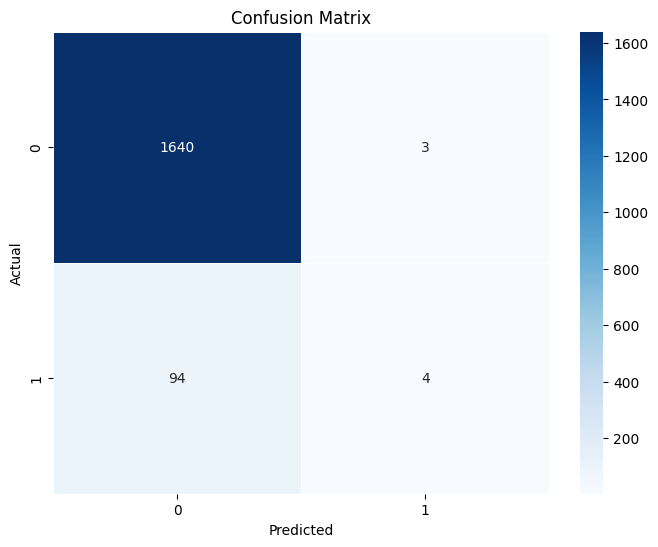

In [34]:
from hyperopt import fmin, tpe, hp
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import csv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import chain
    
def model_training(df, classifier):
    
    print("Number of records: ", df.count())
    
    features = df.columns[1:-1]
    
    train_df, test_df = t_t_split(df)
    
        
    def compute_weights(train_df):
        y_collect = train_df.select("label").groupBy("label").count().collect()
        unique_y = [x["label"] for x in y_collect]
        total_y = sum([x["count"] for x in y_collect])
        unique_y_count = len(y_collect)
        bin_count = [x["count"] for x in y_collect]

        class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
        print(class_weights_spark)
        mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
        train_df = train_df.withColumn("weight", mapping_expr.getItem(F.col("label")))
        return train_df
        
    train_df = compute_weights(train_df)
    
    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    test_df = vector_assembler.transform(test_df)

    if classifier == 'LogisticRegression':
        param_space = {
            'regParam': hp.uniform('regParam', 0.01, 1.0),
            'elasticNetParam': hp.uniform('elasticNetParam', 0.0, 1.0)
        }
        classifier_instance = LogisticRegression(featuresCol="features_vector", labelCol="label", weightCol='weight')
    elif classifier == 'RandomForest':
        param_space = {
            'maxBins': hp.quniform('maxBins', 16, 32, 1),
            'maxDepth': hp.quniform('maxDepth', 20, 30, 1)
        }
        classifier_instance = RandomForestClassifier(featuresCol='features_vector', labelCol='label', weightCol='weight')
    elif classifier == 'GBT':
        param_space = {
            'maxDepth' : hp.quniform("maxDepth", 3, 18, 1),
            'maxBins': hp.quniform('maxBins', 16, 32, 1)
        }
        classifier_instance = GBTClassifier(featuresCol='features_vector', labelCol='label')
    else:
        raise ValueError("Unsupported classifier")
    
    initial_model = classifier_instance
    initial_model = initial_model.fit(train_df)

    def cross_val_train(params):
        classifier_instance.setParams(**params)
        evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
        train, val = train_df.randomSplit([0.9,0.1])
        curr_model = classifier_instance.fit(train)
        predictions = curr_model.transform(val)
        val_metric = evaluator.evaluate(predictions)
        return curr_model, val_metric
#         crossval = CrossValidator(estimator=classifier_instance,
#                                   estimatorParamMaps=[params],
#                                   evaluator=evaluator,
#                                   numFolds=5, parallelism=12)
        
#         cv_model = crossval.fit(train_df)
#         predictions = cv_model.transform(train_df)
#         val_metric = evaluator.evaluate(predictions)
#         return cv_model, val_metric
    
    
    def objective(params):
        model, metric = cross_val_train(params)
        return -metric

    # Find the best hyperparameters
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=5)
    print("Best hyperparameters: ", best_params)

    # Train the model with the best hyperparameters
    best_model, final_metric = cross_val_train(best_params)
            
    
    predictions = best_model.transform(test_df)
    true = predictions.select('label').toPandas()
    preds = predictions.select('prediction').toPandas()
    print(classification_report(true, preds))
    
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    return best_model, train_df, test_df
    
model, train_df, test_df = model_training(df, 'GBT')

      ff_assets_gr  ff_debt_entrpr_val  ff_gross_cf_debt  ff_dil_adj  \
0        39.423005           -0.013811      -2334.600441    0.000000   
1        23.098829            0.292476          9.543917    0.000000   
2       571.298680            0.023440     -10704.572474   -0.101557   
3     15611.057466            0.000000         33.962333    0.000000   
4       118.602644            0.218860        -79.064771    0.000000   
...            ...                 ...               ...         ...   
1680      4.781715            0.014954       -207.918930    0.000000   
1681    166.278173            0.000000      -1136.033520    0.000000   
1682      4.688472            0.139930         76.718412    0.000000   
1683    666.444711            0.001897       -270.638031    0.000000   
1684     60.641084            0.041254       7997.714683    0.000000   

       ff_xord  ff_inc_sund  ff_net_inc_basic_beft_xord  ff_non_oper_exp  \
0    -1.762454     1.711586                   -8.054668    

check_additivity requires us to run predictions which is not supported with spark, ignoring. Set check_additivity=False to remove this warning


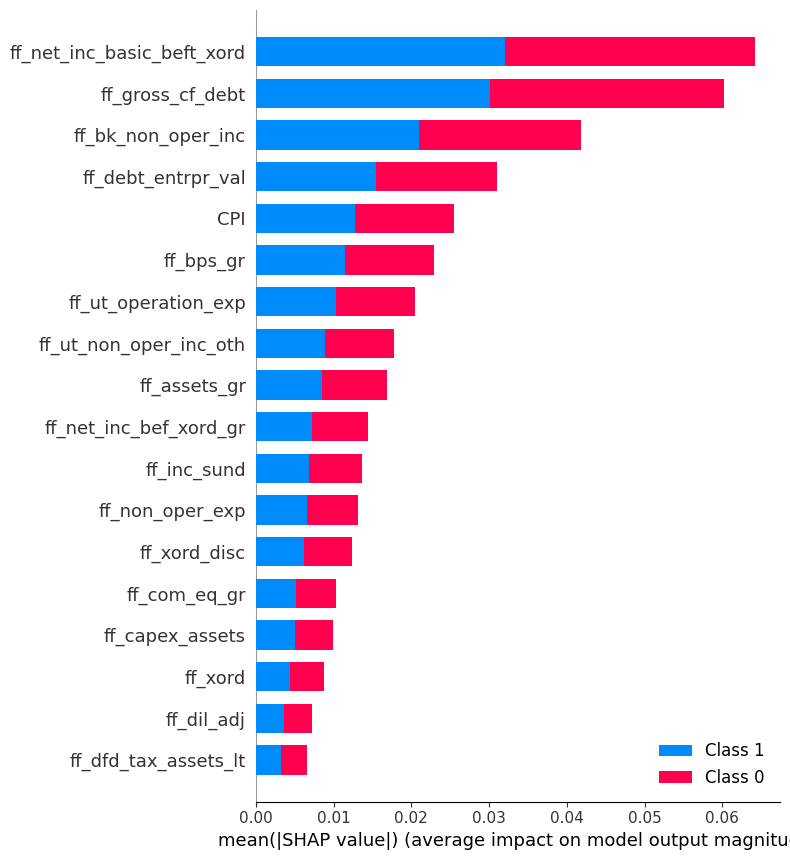

In [32]:
import shap

def feat_analysis(model):
    features = df.columns[1:-1]
    feature_importances = model.featureImportances
    feature_importances = feature_importances.toArray()
    sorted_idx = np.argsort(feature_importances)[::-1]
    sorted_features = [features[i] for i in sorted_idx]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align="center")
    plt.xticks(range(len(feature_importances)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances")
    plt.show()
    
    
def shapley(model, train, test):
    exclude_columns = ['fsym_id',  'label', 'features_vector']
    train = train.toPandas()
    test = test.toPandas()
    X_train = train.drop(exclude_columns, axis=1)
    X_test = test.drop(exclude_columns, axis=1)
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.initjs()
    # print(shap_values.shape)
    shap.summary_plot(shap_values, X_test)
    
    
# feat_analysis(model)
shapley(model, train_df, test_df)

In [3]:
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date'])
df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date'])
df = get_full_seqs(df)

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [4]:
df.show()

2024-01-20 20:53:18,456 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
2024-01-20 20:53:24,727 WARN scheduler.TaskSetManager: Stage 0 contains a task of very large size (2969 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
| fsym_id|        ff_assets_gr|  ff_net_inc_per_emp|  ff_debt_entrpr_val|          ff_fcf_yld|          ff_sga_oth|    ff_gross_cf_debt|          ff_dil_adj|        ff_shs_float|             ff_xord|         ff_inc_sund|ff_net_inc_basic_beft_xord|     ff_non_oper_exp|         ff_cf_ps_gr|           ff_emp_gr|ff_net_inc_bef_xord_gr|        ff_com_eq_gr|       ff_mkt_val_gr|          

33
{0: 0.5287271655863288, 1: 9.202564102564102}
Epoch 1/50
101/101 [==============================] - 1s 5ms/step - loss: 1.3202 - accuracy: 0.4619 - val_loss: 0.7254 - val_accuracy: 0.4373
Epoch 2/50
101/101 [==============================] - 0s 3ms/step - loss: 0.7196 - accuracy: 0.6062 - val_loss: 0.5869 - val_accuracy: 0.9248
Epoch 3/50
101/101 [==============================] - 0s 3ms/step - loss: 0.7013 - accuracy: 0.7229 - val_loss: 0.5476 - val_accuracy: 0.9136
Epoch 4/50
101/101 [==============================] - 0s 3ms/step - loss: 0.5242 - accuracy: 0.8486 - val_loss: 0.4779 - val_accuracy: 0.9136
Epoch 5/50
101/101 [==============================] - 0s 3ms/step - loss: 0.7277 - accuracy: 0.8424 - val_loss: 0.4908 - val_accuracy: 0.8886
Epoch 6/50
101/101 [==============================] - 0s 3ms/step - loss: 0.4345 - accuracy: 0.8771 - val_loss: 0.4322 - val_accuracy: 0.9276
Epoch 7/50
101/101 [==============================] - 0s 3ms/step - loss: 0.4316 - accuracy: 0.8786

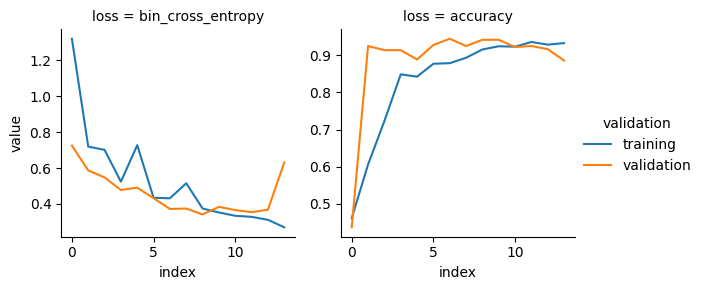

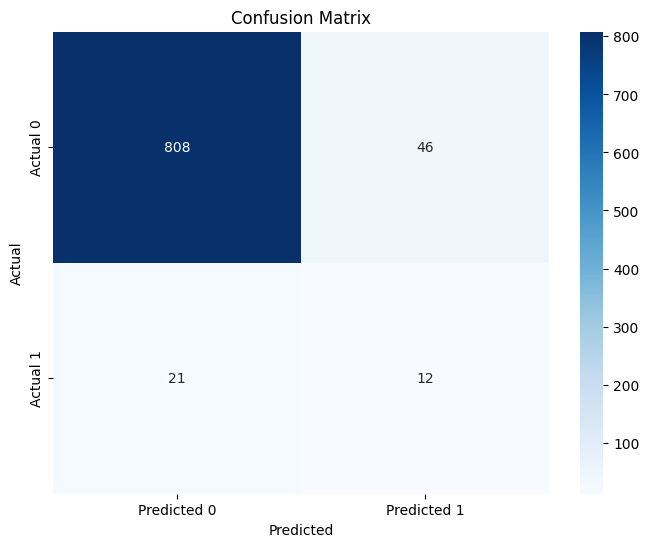

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report


def nn_prepare_seqs(df):
    # print(df.columns)
    print("Number of records: ", df.count())
    df = df.filter(reduce(lambda acc, column: acc & (F.size(col(column)) == 22), df.columns[1:-1], F.lit(True)))
    print("Number of records: ", df.count())
    features = df.columns[1:-1]
    print(features)
    label_col = 'label'

    def convert_to_np_array(row):
        seq_feats = row.seq_feats
        label = row.label
        feat_length = len(seq_feats[0])
        date_length = len(seq_feats[0][0])
        seq_array = np.zeros((feat_length, date_length))
        for i, sublist in enumerate(seq_feats[0]):
            seq_array[i, :] = np.array(sublist)
        seq_array = seq_array.T
        return (seq_array, label)
    
    # train_seqs_rdd = grouped_data.rdd.map(convert_to_np_array)
    train_df, test_df = t_t_split(df)
    
    # train_seqs = []
    # for stock_id, group in df.groupby('fsym_id'):
    #     seq_feats = group[features]
    #     label = group['label']
    #     feat_length = len(seq_feats.iloc[0])
    #     date_length = len(seq_feats.iloc[0,0])
    #     seq_array = np.zeros((feat_length, date_length))
    #     for i, sublist in enumerate(seq_feats.columns):
    #         seq_array[i, :] = np.array(seq_feats[sublist].iloc[0])
    #     seq_array = seq_array.T
    #     train_seqs.append((seq_array, label))
        
        
    # df= df.toPandas()
    # print(df.head())
    # features = df.columns[1:-1]
    # list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
    # df = df.toPandas()
    
    
    
    # for f in features:
    #     df = df.withColumn(f, list_to_vector_udf(f))
    # train_df, test_df = train_test_split(df)
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    
    train_seqs = []
    for stock_id, group in train_df.groupby('fsym_id'):
        seq_feats = group[features]
        label = group['label']
        feat_length = len(seq_feats.iloc[0])
        date_length = len(seq_feats.iloc[0,0])
        seq_array = np.zeros((feat_length, date_length))
        for i, sublist in enumerate(seq_feats.columns):
            seq_array[i, :] = np.array(seq_feats[sublist].iloc[0])
        seq_array = seq_array.T
        train_seqs.append((seq_array, label))
        
    test_seqs = []
    for stock_id, group in test_df.groupby('fsym_id'):
        seq_feats = group[features]
        label = group['label']
        feat_length = len(seq_feats.iloc[0])
        date_length = len(seq_feats.iloc[0,0])
        seq_array = np.zeros((feat_length, date_length))
        for i, sublist in enumerate(seq_feats.columns):
            seq_array[i, :] = np.array(seq_feats[sublist].iloc[0])
        seq_array = seq_array.T
        test_seqs.append((seq_array, label))
    
    return train_seqs, test_seqs

def plot_model_performance(mdl, loss, metric):
    x = pd.DataFrame(mdl.history).reset_index()
    x = pd.melt(x, id_vars='index')
    x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
    x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})
    g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
    g.map(sns.lineplot, 'index','value')
    g.add_legend()
    return g

def nn_training(train_seqs, test_seqs):
    train_X, train_y = zip(*train_seqs)
    test_X, test_y = zip(*test_seqs)

    # Convert lists to numpy arrays
    train_X = np.array(train_X)
    train_y = np.array(train_y)
    test_X = np.array(test_X)
    test_y = np.array(test_y)
    print(np.sum(test_y==1))
    
    class_labels = np.unique(train_y)
    class_weights = compute_class_weight('balanced', classes=class_labels, y=train_y.flatten())
    class_weight_dict = dict(zip(class_labels, class_weights))
    print(class_weight_dict)
    

    # Define the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(train_X.shape[1], train_X.shape[2])),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),  # Additional Dense layer
        tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
        tf.keras.layers.Dense(16, activation='relu'),  # Another Dense layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    loss_fn = keras.losses.BinaryCrossentropy()
    optimizer = keras.optimizers.Adam(
        learning_rate=0.01
    )

    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    # Train the model
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    fit_model = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_split=0.1, class_weight = class_weight_dict, callbacks=[early_stopping])
    plot_model_performance(fit_model, 'bin_cross_entropy','accuracy')

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_X, test_y)
    print(f'Test accuracy: {test_acc}')

    # Make predictions on new data
    predictions = model.predict(test_X)
    for i in range(len(predictions)):
        predictions[i] = 1 if predictions[i] >= 0.5 else 0
    print(classification_report(predictions, test_y.flatten()))
    
    # pred_df = pd.DataFrame()
    # pred_df['prediction'] = predictions
    # pred_df['label'] = test_y
    # confusion_matrix_pandas(pred_df)
    cm = confusion_matrix(test_y, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    

# train_seqs, test_seqs = nn_prepare_seqs(df)
nn_training(train_seqs, test_seqs)

In [ ]:
# spark.stop()